<a href="https://colab.research.google.com/github/satya12388/Satya_tensorflow/blob/main/FineTuning/FoodVisionMilestone_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learning and fine tuning for Food Data Set

### Getting and downloading the data along eith helper function

In [ ]:
# Getting the helper functions
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-19 13:14:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-19 13:14:44 (71.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# importing functions from helper function
from helper_functions import unzip_data,compare_historys,plot_loss_curves,create_tensorboard_callback,make_confusion_matrix

In [ ]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('./101_food_classes_10_percent.zip')

--2024-05-19 13:14:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   185MB/s    in 8.2s    

2024-05-19 13:14:57 (188 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
import os
for dir_name,file_name,images in os.walk('./101_food_classes_10_percent'):
  print(f"there are {len(file_name)} files and {len(images)} images in {dir_name}.")

there are 2 files and 0 images in ./101_food_classes_10_percent.
there are 101 files and 0 images in ./101_food_classes_10_percent/train.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/chicken_wings.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/beef_tartare.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/bruschetta.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/pulled_pork_sandwich.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/beef_carpaccio.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/ravioli.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/omelette.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/spring_rolls.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/grilled_salmon.
there are 0 files and 75 images in ./101_food_classes_10_percent/train/bibimbap.
there are 0 fi

## Converting data to Tensors and visualizing the data

In [ ]:
import tensorflow as tf

# Making Training and testing Data path
train_path = './101_food_classes_10_percent/train'
test_path = './101_food_classes_10_percent/test'

# Converting data to tensors and labels
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                 label_mode = 'categorical',
                                                                 image_size = (224,224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                label_mode = 'categorical',
                                                                image_size = (224,224),
                                                                shuffle = False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


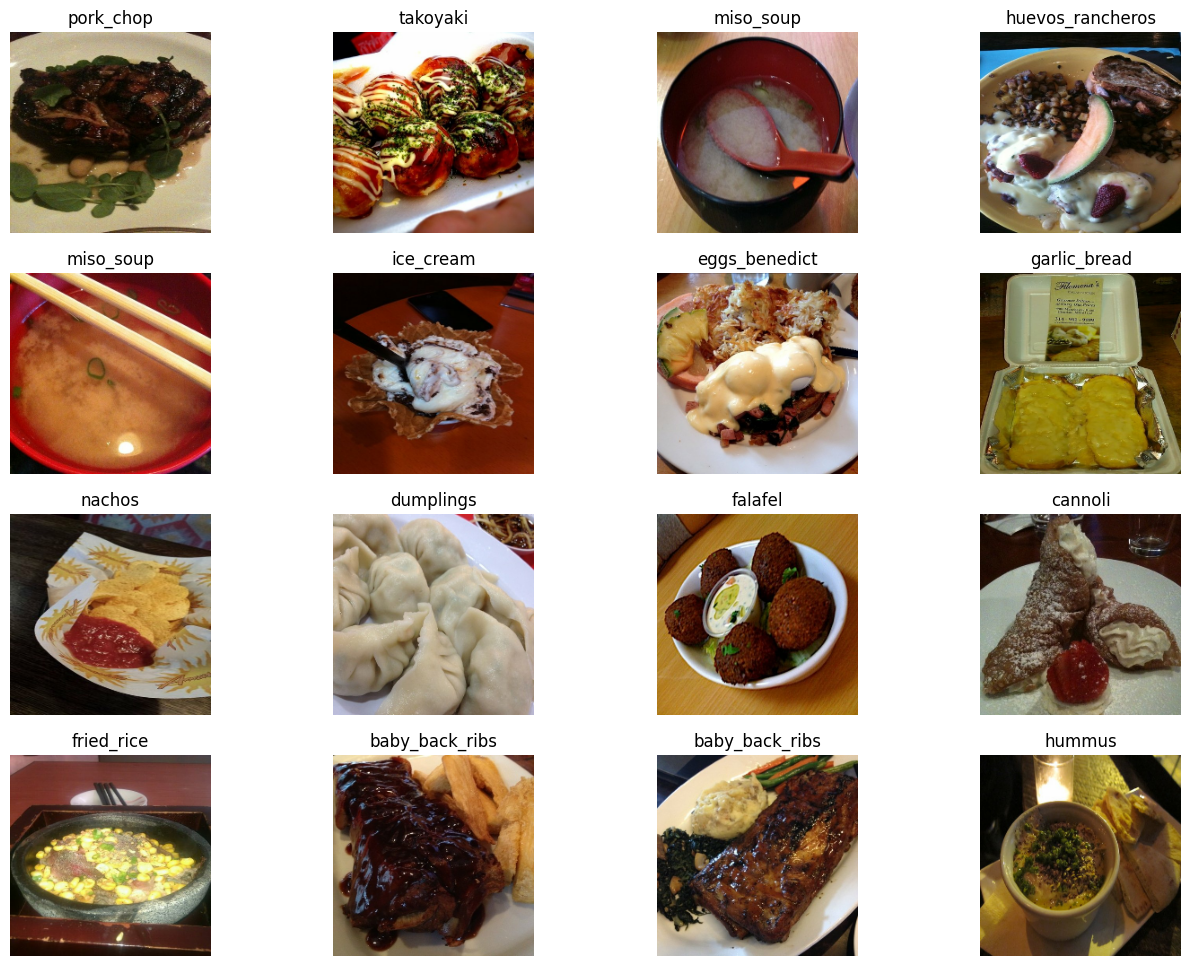

In [ ]:
# Visualizing the data
import matplotlib.pyplot as plt
import numpy as np
classes  = train_data.class_names
plt.figure(figsize = (16,12))
for images,labels in train_data.take(5):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[tf.argmax(labels[i])])
    plt.axis(False)

## Training Feature Extraction Model first with efficient Net b0

In [ ]:
# model Check pont callback
checkpoint_path = './checkpoints/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = True,
                                                         save_freq = 'epoch')

In [ ]:
# building data augmentation layer

from tensorflow.keras import layers

data_aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
],name = 'data_augmentation_layer')


In [ ]:
# Creating a base model

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# creating inputs and outputs along with hidden layers
inputs = layers.Input(shape = (224,224,3),name = 'input_layer')
x = data_aug_layer(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'poooling_layer')(x)

outputs = layers.Dense(101,activation = 'softmax',name = 'output_layer')(x)

model_extraction = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_extraction.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 poooling_layer (GlobalAver  (None, 1280)              0         
 agePooling2D)                                                   
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compile and Fit the model

model_extraction.compile(loss = 'categorical_crossentropy',
                         optimizer = 'Adam',
                         metrics = 'accuracy')

In [ ]:
extract_history = model_extraction.fit(train_data,
                                       epochs = 5,
                                       validation_data = test_data,
                                       validation_steps = int(0.15*len(test_data)),
                                       callbacks = [checkpoint_callback])

## Fine tuning the above extraction model

In [ ]:
# Unfreeze all the layers
base_model.trainable = True

# Freeze all layers except last 5
for layers in base_model.layers[:-5]:
  layers.trainable = False

In [ ]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

In [ ]:
# Compiling Fine tuned Model
model_extraction.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics = ['accuracy'])

# fiting the model
finetune_history = model_extraction.fit(train_data,
                                        epochs = 10,
                                        validation_data = test_data,
                                        validation_steps = int(0.15*len(test_data)),
                                        initial_epoch = extract_history.epoch[-1],
                                        )

In [ ]:
# compare histories

compare_historys(extract_history,finetune_history)

🔑 We identified that fine tuning has overfit the model since the Val loss and val accuracy are almost straight and no improvements

## Saving and loading the model

In [ ]:
model_extraction.save('drive/MyDrive/Tensorflow models/food_vision_mini')

In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/Tensorflow models/food_vision_mini')

In [ ]:
loaded_model.evaluate(test_data)

## making Predictions with test Data

In [ ]:
# Making prediction probability on Test Data
predict_proba = loaded_model.predict(test_data,verbose = 1)
predict_proba

790/790 [==============================] - 1933s 2s/step


array([[4.66434598e-01, 2.42734110e-04, 9.85754058e-02, ...,
        1.76622052e-05, 6.63394481e-03, 1.03979344e-02],
       [9.21670496e-01, 3.83437921e-08, 1.37696147e-03, ...,
        3.02463444e-03, 1.80169695e-06, 2.39688270e-05],
       [5.55942714e-01, 4.66436706e-03, 2.21560616e-02, ...,
        2.43582239e-04, 3.27230082e-04, 2.72737001e-03],
       ...,
       [1.22943864e-04, 2.11230107e-02, 7.64602703e-07, ...,
        8.17055407e-04, 1.81490061e-04, 4.65480030e-01],
       [1.01749869e-02, 1.24667315e-02, 1.07234679e-02, ...,
        2.09548092e-03, 2.47269578e-04, 4.04237837e-01],
       [4.39064950e-02, 1.76682381e-03, 2.47971388e-03, ...,
        2.59243906e-03, 6.71114190e-04, 6.34643018e-01]], dtype=float32)

In [ ]:
predict_proba.shape

(25250, 101)

In [ ]:
# making predictions on test Data
pred_array = predict_proba.argmax(axis=1)
pred_array

array([  0,   0,   0, ..., 100, 100, 100])

In [ ]:
# geting Actual labels
import random
test_labels = []
for images,labels in test_data.unbatch():
  test_labels.append(labels.numpy().argmax())

print(len(test_labels))

25250


In [ ]:
# making confusion matrix
make_confusion_matrix(test_labels,pred_array,classes,figsize=(100,100))

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
classification_report_dict = classification_report(test_labels,pred_array,output_dict=True)

In [ ]:
import pandas as pd

class_f1_scores = {}
for k,v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[classes[int(k)]] = v["f1-score"]

f1_score_report = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
              "f1-scores":list(class_f1_scores.values())}).sort_values("f1-scores")